## 1. Importing Necessary Libraries ##

In [1]:
import re

import pickle as pkl
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from nltk import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation , Embedding, GlobalMaxPooling1D, Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

D:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2550210358554002063
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3157314764
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5080481028806326649
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## 2. Reading and Visualization of the dataset

In [3]:
dataset_dir = 'dataset\\emotion_dataset.csv'
glove_dir = 'glove\\glove.twitter.27B.100d.txt'

In [4]:
nltk_stop_words = list(stopwords.words('english'))

In [5]:
dataset = pd.read_csv(dataset_dir, sep=',', index_col=0)
dataset.head()

,emotion,text
0,joy,"During the period of falling in love, each tim..."
1,fear,When I was involved in a traffic accident.
2,anger,When I was driving home after several days of...
3,sadness,When I lost the person who meant the most to me.
4,disgust,The time I knocked a deer down - the sight of ...


In [6]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
dataset.head()

,emotion,text
0,disgust,Being looked at by someone I do not like.
1,disgust,A striking act of ingratitude at a public vehi...
2,shame,I met a friend in a discotheque. he was with a...
3,shame,Failing in the English language exam.
4,shame,I was very drunk at a certain wedding party an...


In [7]:
emotion = np.array(dataset['emotion'])

In [8]:
class_values = dataset['emotion'].unique()
print(class_values)

['disgust' 'shame' 'anger' 'joy' 'guilt' 'sadness' 'fear']


In [9]:
dataset.groupby('emotion')['text'].count()

emotion
anger      1096
disgust    1096
fear       1095
guilt      1093
joy        1094
sadness    1096
shame      1096
Name: text, dtype: int64

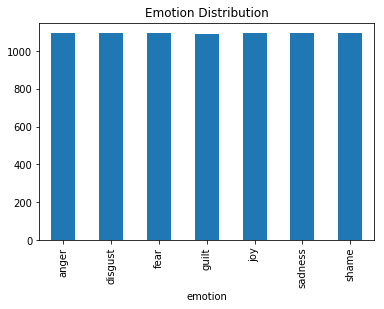

In [10]:
dataset.groupby('emotion')['text'].count().plot(kind='bar' , title= 'Emotion Distribution')

## 3. Preprocessing the Tweets

In [11]:
def preprocess_word(word):
    # Remove punctuation
    word = word.strip('"?!,.():;')
    # Convert more than 2 letter repetitions to 2 letter
    # funnnnny --> funny
    word = re.sub(r'(.)\1+', r'\1\1', word)
    # Remove - & '
    #word = re.sub(r'(-|\')', '', word)
    return word


In [12]:
def is_valid_word(word):
    # Check if word begins with an alphabet
    return (re.search(r'^[a-zA-Z][a-z0-9A-Z\._]*$', word) is not None)


In [13]:
def handle_emojis(text):
    # Smile -- :), : ), :-), (:, ( :, (-:, :')
    text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' smile ', text)
    # Laugh -- :D, : D, :-D, xD, x-D, XD, X-D
    text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' laugh ', text)
    # Love -- <3, :*
    text = re.sub(r'(<3|:\*)', ' love ', text)
    # Wink -- ;-), ;), ;-D, ;D, (;,  (-;
    text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' affection ', text)
    # Sad -- :-(, : (, :(, ):, )-:
    text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' sad ', text)
    # Cry -- :,(, :'(, :"(
    text = re.sub(r'(:,\(|:\'\(|:"\()', ' cry ', text)
    return text

In [14]:
def preprocess_text(text):
    processed_text = []
    # Convert to lower case
    text = text.lower()
    #HTML removed
    #html_process = BS(text, 'html.parser')
    #text = html_process.get_text()
    
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    # Replaces URLs with the word URL
    text = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', ' ', text)
    # Replace @handle with the word USER_MENTION
    text = re.sub(r'@[\S]+', ' ', text)
    # Replaces #hashtag with hashtag
    text = re.sub(r'#(\S+)', r' \1 ', text)
    # Remove RT (retext)
    text = re.sub(r'\brt\b', '', text)
    # Replace 2+ dots with space
    text = re.sub(r'\.{2,}', ' ', text)
    # Strip space, " and ' from text
    #text = text.strip(' "\'')
    # Replace emojis with either EMO_POS or EMO_NEG
    text = handle_emojis(text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Striping numbers from the text
    text = re.sub(r'\d+', '', text)
    
    
    words = text.split()
    
    stemmer = SnowballStemmer('english')

    #Removing Stop Words and Stemming the Words
    for word in words:
        word = preprocess_word(word)
        #if word not in nltk_stop_words and len(word)> 2:
        
        if is_valid_word(word):
            stemmed_words = stemmer.stem(word)
            processed_text.append(word)

    return ' '.join(processed_text)

In [15]:
dataset['text'] = dataset['text'].map(lambda x: preprocess_text(x))
dataset.head()

,emotion,text
0,disgust,being looked at by someone i do not like
1,disgust,a striking act of ingratitude at a public vehicle
2,shame,i met a friend in a discotheque he was with a ...
3,shame,failing in the english language exam
4,shame,i was very drunk at a certain wedding party an...


### Plot Function

In [16]:
def plot_model(history):
    # Plot training & validation accuracy values
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


## 4. Label Encoding & Vectorization


In [17]:
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(emotion)

print(label_encoder.classes_)

label_OneHotEncoder = OneHotEncoder()
encoded_label = label_OneHotEncoder.fit_transform(encoded_label.reshape(-1,1)).toarray()

['anger' 'disgust' 'fear' 'guilt' 'joy' 'sadness' 'shame']


In [18]:
vocabulary_size = 10000
input_length = 100

In [19]:
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(dataset['text'])
sequences = tokenizer.texts_to_sequences(dataset['text'])
data = pad_sequences(sequences, maxlen = input_length)

file = open('saved_model\\tokenizer.pickle', 'wb')
pkl.dump(tokenizer, file, protocol = pkl.HIGHEST_PROTOCOL)
file.close()

In [20]:
train_data, test_data, train_label, test_label = train_test_split(data, encoded_label, test_size = 0.2)

In [21]:
num_classes = len(class_values)
validation_split = 0.1

## 5. Model Creation & Training

### 5.1 Stacked LSTM Model

In [22]:
output_dim = 1000
dense_input = 1000

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 128
l2_lstm_units = 64

validation_split = 0.2
epochs = 20

callback_patience = 2

In [23]:
callback = [EarlyStopping(monitor='val_loss', patience = callback_patience)]

In [24]:
model = Sequential()

model.add(Embedding(vocabulary_size, dense_input, input_length = input_length))
model.add(Dense(dense_input, activation='tanh'))

model.add(LSTM(l1_lstm_units, dropout = l1_dropout, recurrent_dropout = l1_recurrent_dropout, 
                             return_sequences = True, activation='tanh'))
model.add(LSTM(l2_lstm_units, dropout = l2_dropout, recurrent_dropout = l2_recurrent_dropout, 
                             return_sequences = False, activation='tanh'))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 1000)         10000000  
_________________________________________________________________
dense (Dense)                (None, 100, 1000)         1001000   
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          578048    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 11,628,911
Trainable params: 11,628,911
Non-trainable params: 0
_________________________________________________________________


D:\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 4905 samples, validate on 1227 samples
Epoch 1/20
4905/4905 [==============================] - 110s 22ms/step - loss: 0.3689 - acc: 0.8636 - val_loss: 0.3133 - val_acc: 0.8797
Epoch 2/20
4905/4905 [==============================] - 110s 22ms/step - loss: 0.2476 - acc: 0.9044 - val_loss: 0.3219 - val_acc: 0.8771
Epoch 3/20
4905/4905 [==============================] - 113s 23ms/step - loss: 0.1538 - acc: 0.9439 - val_loss: 0.3437 - val_acc: 0.8726


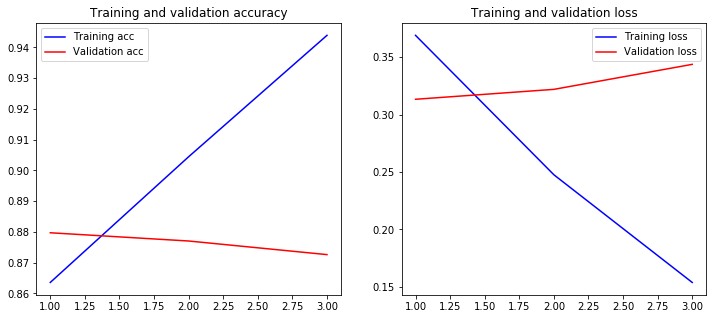

In [26]:
history = model.fit(train_data, train_label, validation_split = validation_split, epochs=epochs, 
                    shuffle = True, callbacks = callback)

plot_model(history)

In [27]:
model.evaluate(test_data, test_label, verbose = 1)

1534/1534 [==============================] - 14s 9ms/step


[0.32418900530061634, 0.8821940885218057]

In [28]:
model.save('saved_model\model_1.h5')

### 5.2 Stacked LSTM with 1D Convolutions

In [29]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 5

pool_size = 4

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

In [30]:
model_conv = Sequential()

model_conv.add(Embedding(vocabulary_size, output_dim, input_length = input_length, trainable=False))
model_conv.add(Dropout(dropout))
#model_conv.add(Dense(output_dim, activation='tanh'))

model_conv.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, activation = 'relu'))
model_conv.add(MaxPooling1D(pool_size = pool_size))

model_conv.add(LSTM(l1_lstm_units , dropout = l1_dropout, return_sequences=True, activation='relu'))
model_conv.add(LSTM(l2_lstm_units , dropout = l2_dropout, return_sequences=False, activation='relu'))

model_conv.add(Dense(num_classes, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [31]:
model_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 100)           50100     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 24, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 64)            42240     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total para

Train on 4905 samples, validate on 1227 samples
Epoch 1/20
4905/4905 [==============================] - 31s 6ms/step - loss: 0.4110 - acc: 0.8570 - val_loss: 0.4097 - val_acc: 0.8571
Epoch 2/20
4905/4905 [==============================] - 26s 5ms/step - loss: 0.4093 - acc: 0.8571 - val_loss: 0.4086 - val_acc: 0.8571
Epoch 3/20
4905/4905 [==============================] - 25s 5ms/step - loss: 0.4076 - acc: 0.8571 - val_loss: 0.4053 - val_acc: 0.8571
Epoch 4/20
4905/4905 [==============================] - 26s 5ms/step - loss: 0.4015 - acc: 0.8572 - val_loss: 0.3943 - val_acc: 0.8588
Epoch 5/20
4905/4905 [==============================] - 27s 5ms/step - loss: 0.3896 - acc: 0.8589 - val_loss: 0.3845 - val_acc: 0.8604
Epoch 6/20
4905/4905 [==============================] - 27s 5ms/step - loss: 0.3739 - acc: 0.8645 - val_loss: 0.3685 - val_acc: 0.8649
Epoch 7/20
4905/4905 [==============================] - 27s 5ms/step - loss: 0.3564 - acc: 0.8667 - val_loss: 0.3633 - val_acc: 0.8660
Epoch 8

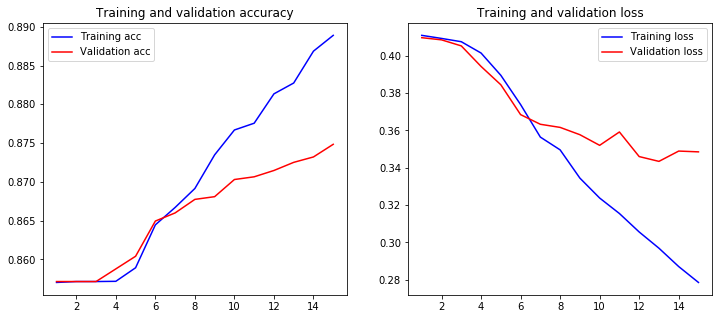

In [32]:
history = model_conv.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, 
                         shuffle = True, callbacks = callback)

plot_model(history)

In [33]:
model_conv.save('saved_model\model_conv.h5')

In [34]:
model_conv.evaluate(test_data, test_label, verbose = 1)

1534/1534 [==============================] - 3s 2ms/step


[0.34111062585918966, 0.8760477037908512]

In [35]:
embeddings_index = dict()
f = open(glove_dir, encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [36]:
embedding_matrix = np.zeros((vocabulary_size, output_dim))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

In [37]:
output_dim = 100
dense_input = 1000

dropout = 0.3

conv1D_filters = 100
conv1D_kernel_size = 4

pool_size = 5

l1_dropout = 0.2
l1_recurrent_dropout = 0.2

l2_dropout = 0.2
l2_recurrent_dropout = 0.2

l1_lstm_units = 64
l2_lstm_units = 32

### 5.3 Stacked LSTM with 1D Convolutions on pretrained vector

In [38]:
model_glove = Sequential()
model_glove.add(Embedding(vocabulary_size, output_dim, input_length = input_length, 
                          weights=[embedding_matrix], trainable=False))
model_glove.add(Dropout(dropout))

model_glove.add(Dense(output_dim, activation='relu'))

model_glove.add(Conv1D(filters = conv1D_filters, kernel_size = conv1D_kernel_size, 
                       activation='relu'))
model_glove.add(MaxPooling1D(pool_size = pool_size))

model_glove.add(LSTM(l1_lstm_units , dropout = l1_dropout,
                     return_sequences=True, activation='relu'))
model_glove.add(LSTM(l2_lstm_units , dropout = l2_dropout,
                     return_sequences=False , activation='relu'))

model_glove.add(Dense(7, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
model_glove.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100)          0         
_________________________________________________________________
dense_3 (Dense)              (None, 100, 100)          10100     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 97, 100)           40100     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 19, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 19, 64)            42240     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
__________

Train on 4905 samples, validate on 1227 samples
Epoch 1/20
4905/4905 [==============================] - 25s 5ms/step - loss: 0.4099 - acc: 0.8571 - val_loss: 0.4095 - val_acc: 0.8571
Epoch 2/20
4905/4905 [==============================] - 22s 4ms/step - loss: 0.4078 - acc: 0.8571 - val_loss: 0.4050 - val_acc: 0.8571
Epoch 3/20
4905/4905 [==============================] - 21s 4ms/step - loss: 0.3914 - acc: 0.8585 - val_loss: 0.3664 - val_acc: 0.8638
Epoch 4/20
4905/4905 [==============================] - 21s 4ms/step - loss: 0.3601 - acc: 0.8652 - val_loss: 0.3452 - val_acc: 0.8681
Epoch 5/20
4905/4905 [==============================] - 22s 4ms/step - loss: 0.3457 - acc: 0.8698 - val_loss: 0.3283 - val_acc: 0.8751
Epoch 6/20
4905/4905 [==============================] - 22s 4ms/step - loss: 0.3296 - acc: 0.8746 - val_loss: 0.3158 - val_acc: 0.8780
Epoch 7/20
4905/4905 [==============================] - 22s 4ms/step - loss: 0.3193 - acc: 0.8784 - val_loss: 0.3092 - val_acc: 0.8802
Epoch 8

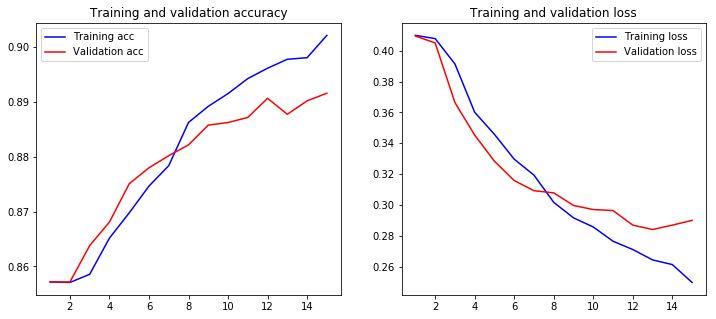

In [40]:
history = model_glove.fit(train_data, train_label, validation_split = validation_split, epochs = epochs, 
                          shuffle = True, callbacks = callback)

plot_model(history)

In [41]:
model_glove.save('saved_model\model_glove.h5')

In [42]:
model_glove.evaluate(test_data, test_label, verbose = 1)

1534/1534 [==============================] - 3s 2ms/step


[0.28437979375601125, 0.8962563091337759]

In [43]:
model_conv.predict(test_data)

array([[4.49284315e-02, 5.83278649e-02, 7.91815370e-02, ...,
        3.84170949e-01, 5.23619056e-02, 2.19246209e-01],
       [1.75495833e-01, 2.11243629e-01, 2.82221794e-01, ...,
        6.98765963e-02, 6.75012693e-02, 1.14338405e-01],
       [5.31904817e-01, 3.34906615e-02, 3.14568490e-01, ...,
        5.30982332e-04, 1.58183705e-02, 5.36657646e-02],
       ...,
       [1.72065303e-01, 1.43964589e-01, 1.75923765e-01, ...,
        9.02590975e-02, 1.11923255e-01, 1.73275530e-01],
       [9.20550376e-02, 1.29976034e-01, 9.66612697e-02, ...,
        2.82795489e-01, 1.54296830e-01, 1.41564369e-01],
       [7.34430552e-02, 9.87241864e-02, 9.39606875e-02, ...,
        2.88968801e-01, 1.30074367e-01, 1.87438369e-01]], dtype=float32)

## 6. Testing the all the above models with a random text

In [44]:
test_text = 'I am not happy'
test_text = pd.Series(preprocess_text(test_text))

sequences = tokenizer.texts_to_sequences(test_text)
data = pad_sequences(sequences, maxlen = input_length)

##### label_encoder.classes_[np.argmax(model.predict(data))]

In [45]:
label_encoder.classes_[np.argmax(model_conv.predict(data))]

'sadness'

In [46]:
label_encoder.classes_[np.argmax(model_glove.predict(data))]

'sadness'

In [47]:
print(label_encoder.classes_)

['anger' 'disgust' 'fear' 'guilt' 'joy' 'sadness' 'shame']


In [48]:
np.around(model.predict(data), decimals = 2)

array([[0.02, 0.02, 0.02, 0.04, 0.6 , 0.24, 0.07]], dtype=float32)

In [49]:
np.around(model_conv.predict(data), decimals = 2)

array([[0.12, 0.13, 0.11, 0.14, 0.15, 0.19, 0.16]], dtype=float32)

In [50]:
np.around(model_glove.predict(data), decimals = 2)

array([[0.09, 0.12, 0.18, 0.14, 0.1 , 0.2 , 0.17]], dtype=float32)

## 7. Reference

1. https://github.com/sinmaniphel/py_isear_dataset [Dataset]